In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas.io.formats.style as style
import seaborn as sns

from utils import build_heatmap_analysis, search_best_parameters, build_model
from utils import COLUMNS_NEW_DESC, NUM_COLUMNS, CAT_COLUMNS, TARGET_COLUMN

%reload_ext autoreload
%autoreload 1
%aimport utils

%matplotlib inline

DATA_PATH = '../data/raw'
DATA_FILENAME = 'heart.csv'

SEED = 5
RANDOM_STATES = [1, 2, 3, 4, 5, 42, 111]

In [2]:
%%html
<style>
table {float:left}
</style>

## Column Descriptions

|  n  | column   | description |
| :-: | -        | :- |
|  1. | age      | is the age of candidate                                 |
|  2. | sex      | has numeric values, 1 denotes male and 0 denotes female |
|  3. | cp       | pain has values between 0-3, the higher the number, the lesser are the odds of heart attack |
|  4. | trestbps | resting blood pressure is normal pressure with no exercise |
|  5. | chol     | serum cholestoral in mg/dl |
|  6. | fbs      | fasting blood pressure is blood sugar taken after a long gap between a meal and the test (> 120 mg/dl) |
|  7. | restecg  | resting electrocardiographic results (values: 0,1,2) |
|  8. | thalach  | the maximum heart rate achieved |
|  9. | exang    | exercise induced angina is chest pain while exercising or doing any physical activity |
| 10. | oldpeak  | ST depression is the difference between value of ECG at rest and after exercise (oldpeak) |
| 11. | slope    | ST Slope is the tangent to the depression value |
| 12. | ca       | the number of major blood vessels (0-3) supplying blood to heart blocked |
| 13. | thal     | the types of thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect) |
| 14. | target   | prediction: 1 &mdash; Heart attack occured, 0 &mdash; din't take occur |

In [3]:
df_orig = pd.read_csv(os.path.join(DATA_PATH, DATA_FILENAME))
df_orig.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df_orig.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [5]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


&nbsp;  
Renaming the column headers for better understanding of visualizations.

In [6]:
df = df_orig.rename(columns = COLUMNS_NEW_DESC)

&nbsp;  
Replacing the values for Sex and Heart_Attack colummns as these will make the understanding of visualizations better instead of numeric values.

In [7]:
df_vis = df.copy()
df_vis['Sex'].replace({1 : 'Male', 0 : 'Female'}, inplace = True)
df_vis['Heart_attack'].replace({ 1 : 'Heart_attack - Yes', 0 : 'Heart_attack - No'}, inplace = True)

## Analysis of data

In [8]:
build_heatmap_analysis(df_vis, ['Sex','Age'], 'Heart_attack', 'Reds')

,Sex,Age,Heart_attack
59,Male,58,13
58,Male,57,13
60,Male,59,13
53,Male,52,12
55,Male,54,11
45,Male,44,9
52,Male,51,8
57,Male,56,8
61,Male,60,7
65,Male,64,7


&nbsp;  
This shows the total number of heart attacks that have occured for a particular age in case of males and females. In the top 20 count of heart attack, males have witnessed more heart attacks for their ages.

In [9]:
build_heatmap_analysis(df_vis, ['Sex','Chest_pain'], 'Heart_attack', 'Purples')

,Sex,Chest_pain,Heart_attack
4,Male,0,104
6,Male,2,52
0,Female,0,39
2,Female,2,35
5,Male,1,32
7,Male,3,19
1,Female,1,18
3,Female,3,4


&nbsp;  
The Males having chest pain type 0 suffered the most heart attacks and type 2 the second highest. This trend is same for females.

In [10]:
build_heatmap_analysis(df_vis, ['Sex','Resting_blood_pressure'], 'Heart_attack', 'Greens')

,Sex,Resting_blood_pressure,Heart_attack
46,Male,120,27
54,Male,130,24
60,Male,140,22
40,Male,110,16
15,Female,130,12
50,Male,125,11
21,Female,140,10
66,Male,150,10
10,Female,120,10
52,Male,128,9


&nbsp;  
The resting blood pressure and the cases of heart attack for such pressure in case of males and females.

In [11]:
build_heatmap_analysis(df_vis, ['Sex','Cholesterol'], 'Heart_attack', 'Blues')

,Sex,Cholesterol,Heart_attack
115,Male,212,5
109,Male,204,4
135,Male,234,4
134,Male,233,4
172,Male,282,4
150,Male,254,4
48,Female,269,4
144,Male,246,3
143,Male,245,3
141,Male,243,3


&nbsp;  
Generally males having high cholesterol had higher cases of heart attacks than females at the same Cholesterol.

In [12]:
build_heatmap_analysis(df_vis, ['Sex','Fasting_blood_sugar'], 'Heart_attack', 'Reds')

,Sex,Fasting_blood_sugar,Heart_attack
2,Male,0,174
0,Female,0,84
3,Male,1,33
1,Female,1,12


&nbsp;  
This shows relation of Fasting blood sugar with heart attack in case of Male and Females.

In [13]:
build_heatmap_analysis(df_vis, ['Sex','ECG_results'], 'Heart_attack', 'Oranges')

,Sex,ECG_results,Heart_attack
3,Male,0,103
4,Male,1,103
1,Female,1,49
0,Female,0,44
2,Female,2,3
5,Male,2,1


&nbsp;  
This shows the lower the ECG Results, the more cases of heart attack occurred.

In [14]:
build_heatmap_analysis(df_vis, ['Sex','Maximum_heart_rate'], 'Heart_attack', 'PuRd', display_lines = 20)

,Sex,Maximum_heart_rate,Heart_attack
86,Male,144,7
77,Male,132,7
103,Male,162,7
113,Male,173,7
82,Male,140,6
42,Female,172,6
91,Male,150,6
70,Male,125,6
97,Male,156,6
34,Female,163,5


&nbsp;  
The maximum heart rate varied for heart attack and were higher for males resulting in heart attack.

In [15]:
build_heatmap_analysis(df_vis, ['Sex','Exercise_induced_angina'], 'Heart_attack', 'BuPu')

,Sex,Exercise_induced_angina,Heart_attack
2,Male,0,130
3,Male,1,77
0,Female,0,74
1,Female,1,22


&nbsp;  
Exercise induced chest pain was higher in males and more resulted in Heart attacks.

In [16]:
build_heatmap_analysis(df_vis, ['Sex','ST_depression'], 'Heart_attack', 'YlGn')

,Sex,ST_depression,Heart_attack
27,Male,0.000000,64
0,Female,0.000000,35
37,Male,1.200000,13
34,Male,0.800000,10
36,Male,1.000000,9
41,Male,1.800000,8
38,Male,1.400000,8
33,Male,0.600000,8
43,Male,2.000000,7
40,Male,1.600000,7


&nbsp;  
The lower the depression, the higher the cases were for heart attack.

In [17]:
build_heatmap_analysis(df_vis, ['Sex','ST_slope'], 'Heart_attack', 'RdPu')

,Sex,ST_slope,Heart_attack
5,Male,2,96
4,Male,1,95
2,Female,2,46
1,Female,1,45
3,Male,0,16
0,Female,0,5


&nbsp;  
The higher the slope value, the higher were the cases for Heart attack.

In [18]:
build_heatmap_analysis(df_vis, ['Sex','Major_vessels'], 'Heart_attack', 'YlOrRd')

,Sex,Major_vessels,Heart_attack
4,Male,0,111
0,Female,0,64
5,Male,1,50
6,Male,2,25
7,Male,3,16
1,Female,1,15
2,Female,2,13
8,Male,4,5
3,Female,3,4


&nbsp;  
The lower the number of vessels blocked, the higher were the heart attack cases. This means that 0 represents that all 4 major blood vessels were blocked and 4 represented all vessels were free for flow.

In [19]:
build_heatmap_analysis(df_vis, ['Sex','Thalassemia_types'], 'Heart_attack', 'PuBuGn')

,Sex,Thalassemia_types,Heart_attack
7,Male,3,102
6,Male,2,87
2,Female,2,79
5,Male,1,17
3,Female,3,15
0,Female,0,1
1,Female,1,1
4,Male,0,1


&nbsp;  
The higher the Thalassemia type, the higher were the cases of heart attack.

<AxesSubplot:>

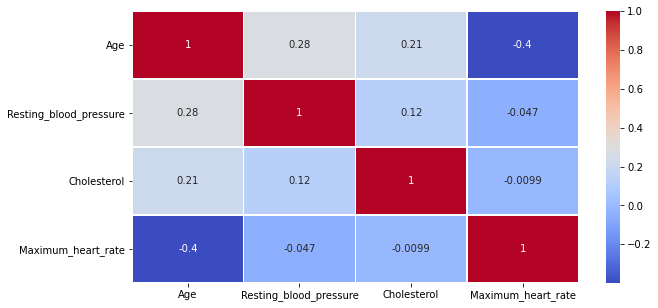

In [20]:
DROPPED_COLUMNS = ['Sex', 'Fasting_blood_sugar', 'Heart_attack', 'Chest_pain', 'ECG_results',
                   'Exercise_induced_angina', 'ST_slope', 'ST_depression', 'Major_vessels',
                   'Thalassemia_types']
df_vis.drop(DROPPED_COLUMNS, axis = 'columns', inplace = True)
plt.figure(figsize=(10,5))
sns.heatmap(df_vis.corr(), annot=True, linewidth=0.5, cmap='coolwarm')

## Univariate Data Analysis

I have dropped categorical variables for heart attack heatmap and only continuous variables are shown.

1. This shows age has some dependency on Resting Blood Pressure and Cholesterol. There is almost no dependecy of Maximum heart rate on Age.
1. Resting blood pressure and Cholesterol also has a low dependency. Maximum heart rate and Resting blood pressure has almost no dependency.



[]

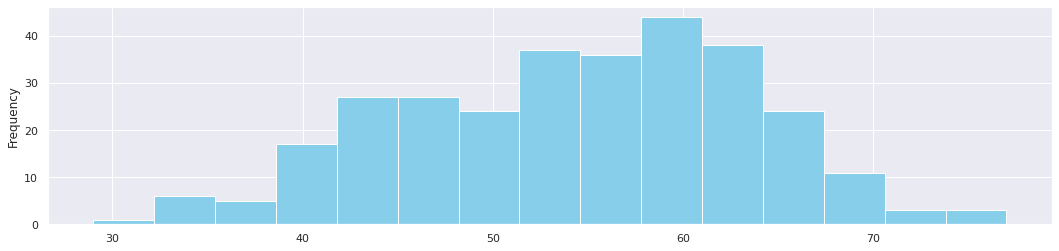

In [21]:
sns.set(rc={'figure.figsize':(18, 4)})
df_vis['Age'].plot.hist(bins = 15, color = 'skyblue')
plt.plot()

&nbsp;  
The span of Ages that were taken for the case study.

[]

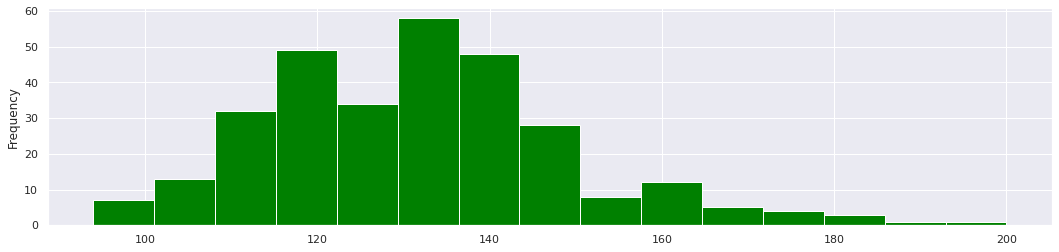

In [22]:
df_vis['Resting_blood_pressure'].plot.hist(bins = 15, color = 'green')
plt.plot()

&nbsp;  
The span of Resting Blood pressure in the case study and they have an average value of 120 &ndash; 140.

[]

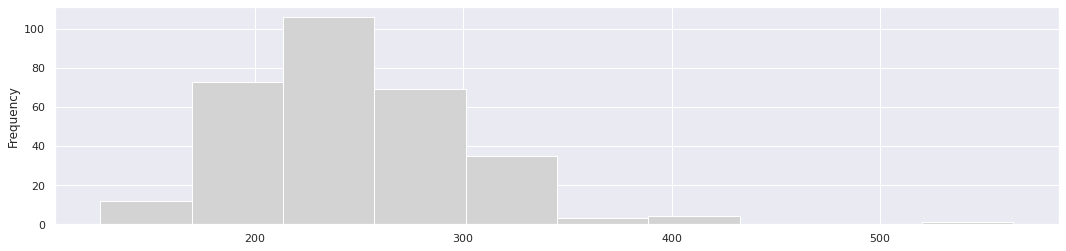

In [23]:
df_vis['Cholesterol'].plot.hist(bins = 10, color = 'lightgrey')
plt.plot()

&nbsp;  
The cholesterol lies between 200 and 300.

[]

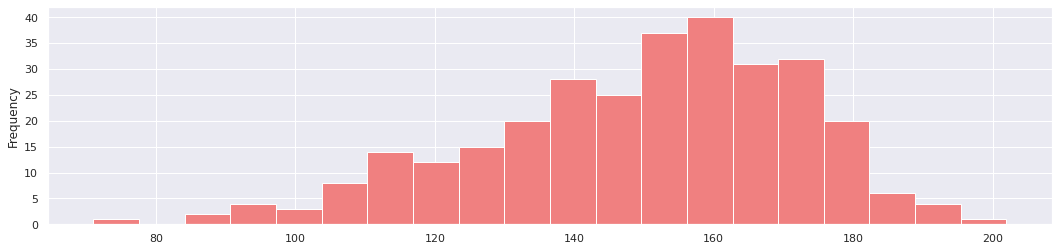

In [24]:
df_vis['Maximum_heart_rate'].plot.hist(bins = 20, color = 'lightcoral')
plt.plot()

&nbsp;  
The maximum heart rate recorded for the patients. The span is showed and it had the maximum average at 160.

## Bivariate Data Analysis

[]

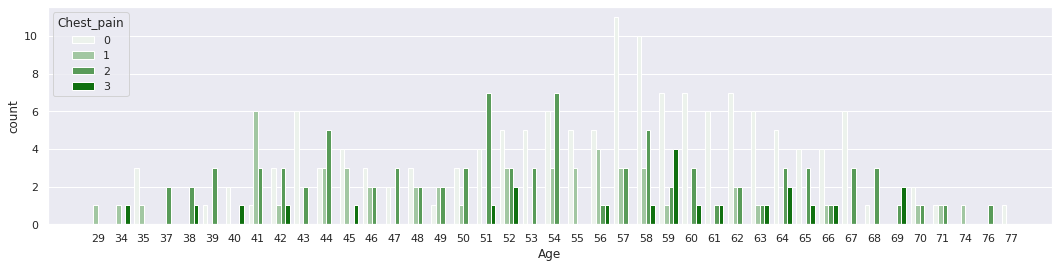

In [25]:
sns.countplot(x = 'Age', hue = 'Chest_pain', data = df, color = 'green')
plt.plot()

&nbsp;  
The dependence of Chest pain on Age.

[]

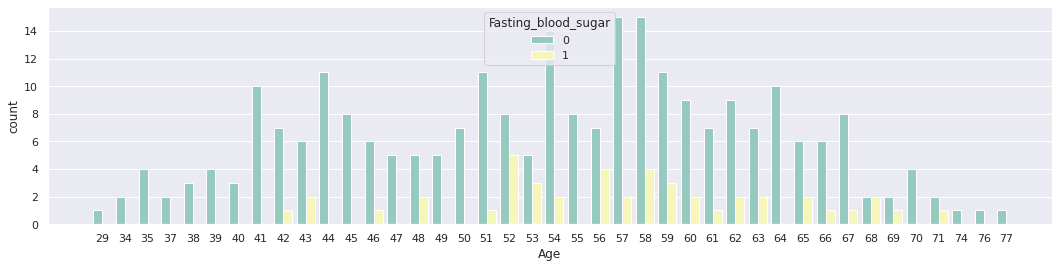

In [26]:
sns.countplot(x = 'Age', hue = 'Fasting_blood_sugar', data = df, palette = "Set3")
plt.plot()

&nbsp;  
The dependence of result of Fasting blood sugar on age.

[]

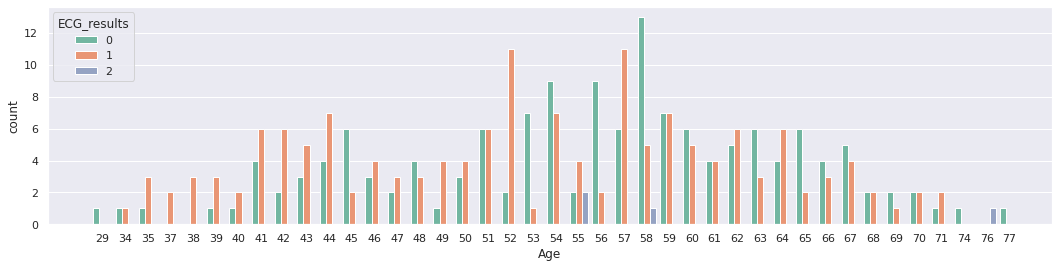

In [27]:
sns.countplot(x = 'Age',hue = 'ECG_results', data = df,palette="Set2")
plt.plot()

&nbsp;  
The dependence of result of ECG on age.

[]

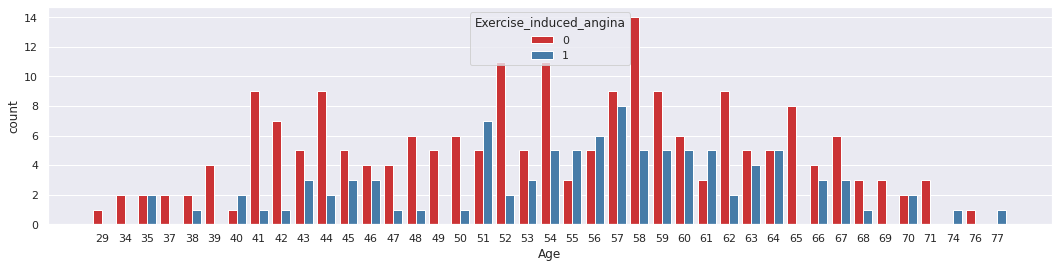

In [28]:
sns.countplot(x = 'Age', hue = 'Exercise_induced_angina', data = df, palette="Set1")
plt.plot()

&nbsp;  
The dependence of result of Exercise Induced Angina on age.

[]

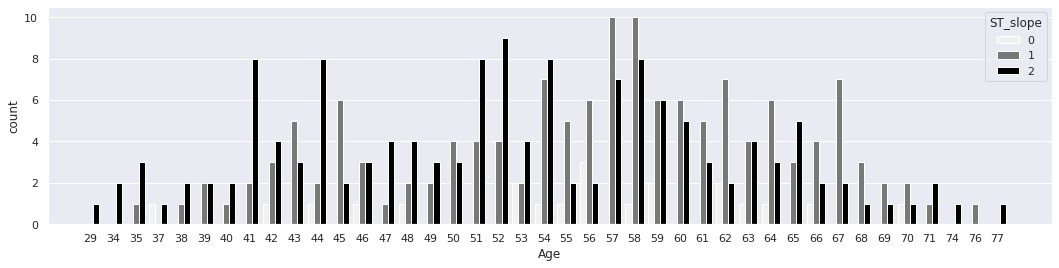

In [29]:
sns.countplot(x = 'Age',hue = 'ST_slope', data = df, color = "black")
plt.plot()

&nbsp;  
The dependence of result of ST Slope on age.

[]

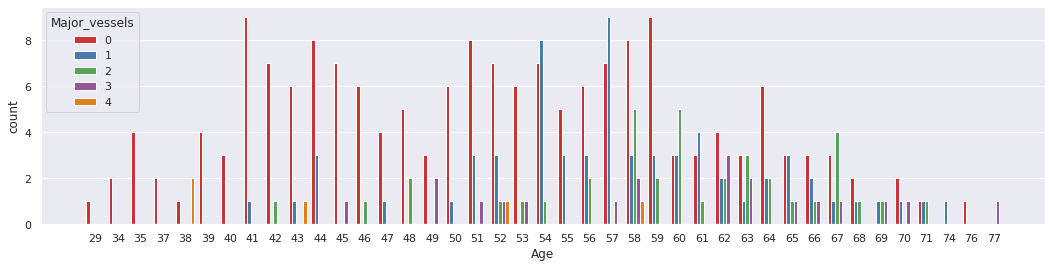

In [30]:
sns.countplot(x = 'Age',hue = 'Major_vessels', data = df, palette='Set1')
plt.plot()

&nbsp;  
The dependence of result of Major vessels being blocked with age.

[]

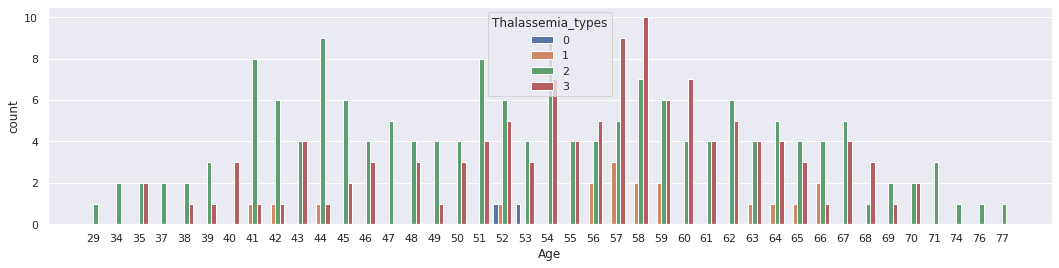

In [31]:
sns.countplot(x = 'Age',hue = 'Thalassemia_types', data = df)
plt.plot()

&nbsp;  
The dependence of result of Thalassemia on age.

[]

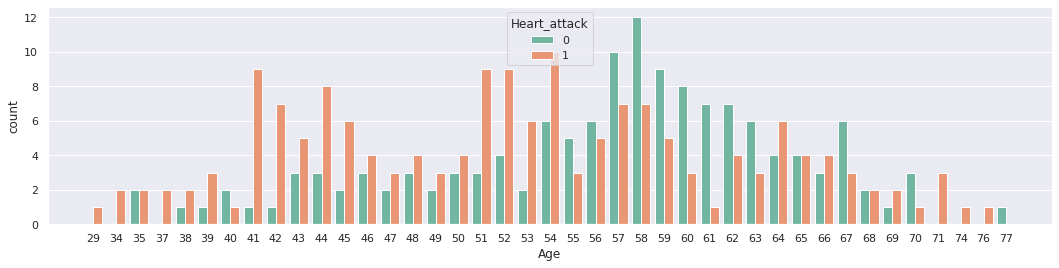

In [32]:
sns.countplot(x = 'Age', hue = 'Heart_attack', data = df, palette = 'Set2')
plt.plot()

&nbsp;  
The dependence of Heart Attack on Age.

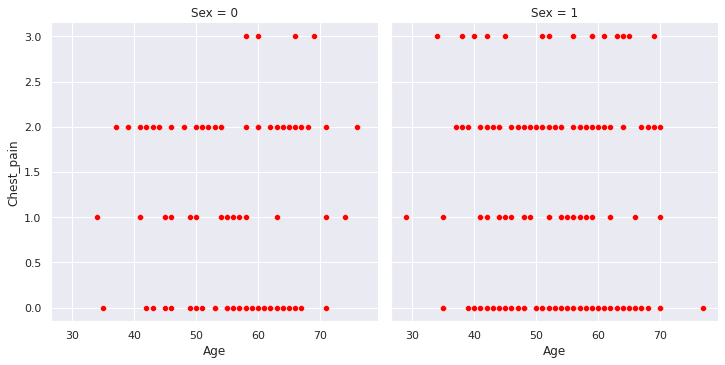

In [33]:
sns.relplot(x ='Age', y ='Chest_pain', col = 'Sex', data = df, color = 'red', height = 5)
plt.show()

&nbsp;  
Relationship between Chest Pain, Age and Sex.

[]

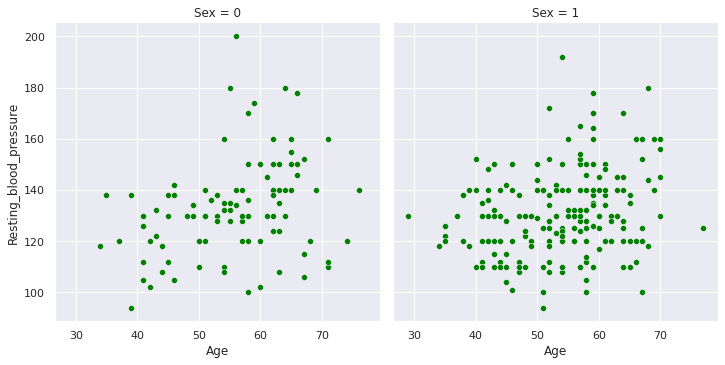

In [34]:
sns.relplot(x ='Age', y ='Resting_blood_pressure', col = 'Sex', data = df, color = 'green')
plt.plot()

&nbsp;  
Relationship between Rising Blood Pressure, Age and Sex.

[]

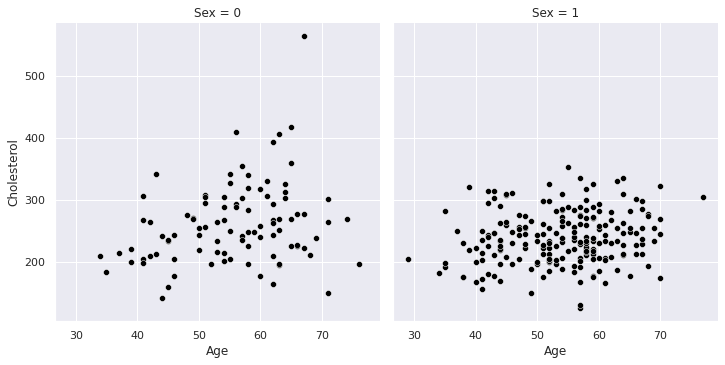

In [35]:
sns.relplot(x ='Age', y ='Cholesterol', col = 'Sex', data = df, color = 'black')
plt.plot()

&nbsp;  
Relationship between Cholesterol, Age and Sex.

[]

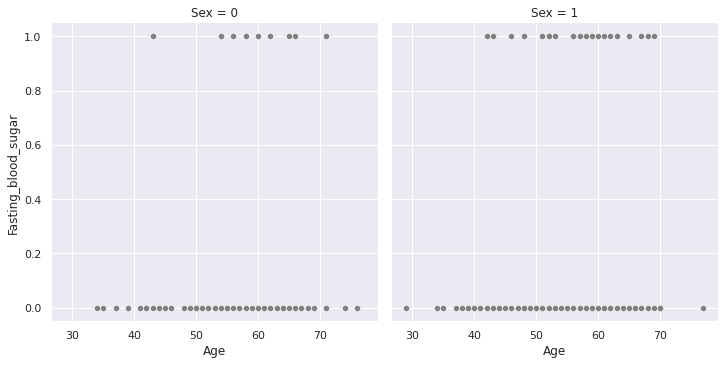

In [36]:
sns.relplot(x ='Age', y ='Fasting_blood_sugar', col = 'Sex', data = df, color = 'grey')
plt.plot()

&nbsp;  
Relationship between Fasting Blood Sugar, Age and Sex.

[]

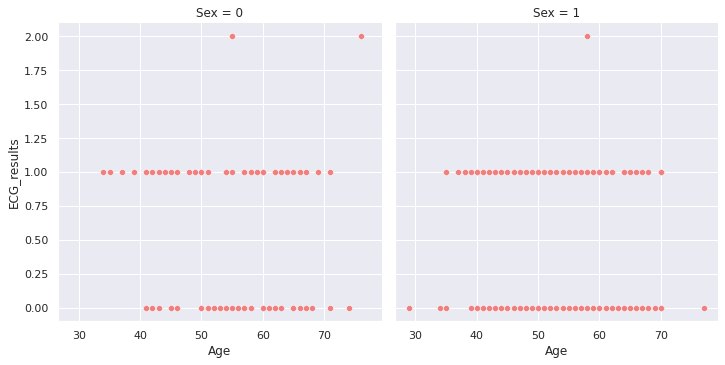

In [37]:
sns.relplot(x ='Age', y ='ECG_results', col = 'Sex', data = df, color = 'lightcoral')
plt.plot()

&nbsp;  
Relationship between ECG Results, Age and Sex.

[]

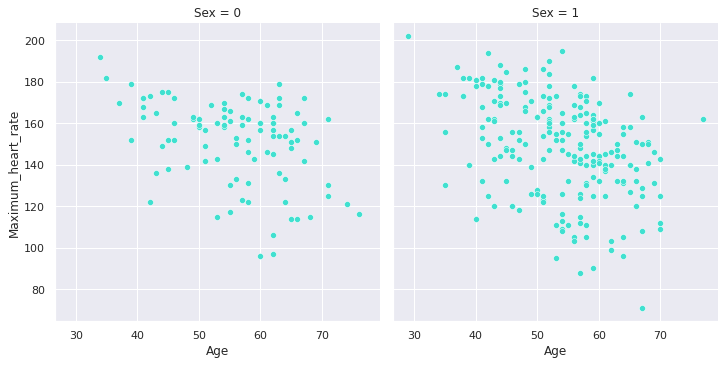

In [38]:
sns.relplot(x ='Age', y ='Maximum_heart_rate', col = 'Sex', data = df, color = 'turquoise')
plt.plot()

&nbsp;  
Relationship between Maximum Heart Rate, Age and Sex.

[]

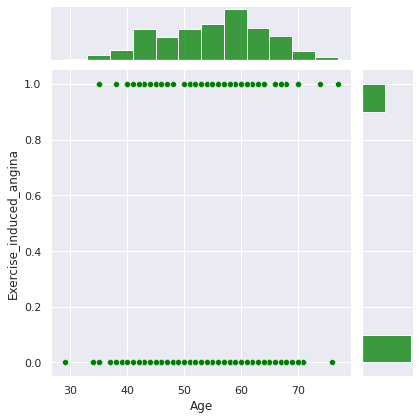

In [39]:
sns.jointplot(x = df['Age'], y = df['Exercise_induced_angina'], data = df, color = 'green')
plt.plot()

&nbsp;  
Relationship between Exercise Induced Angina and Age. The Age peaks at about 60 and Exercise Induced Angina problem is more at value 0.

[]

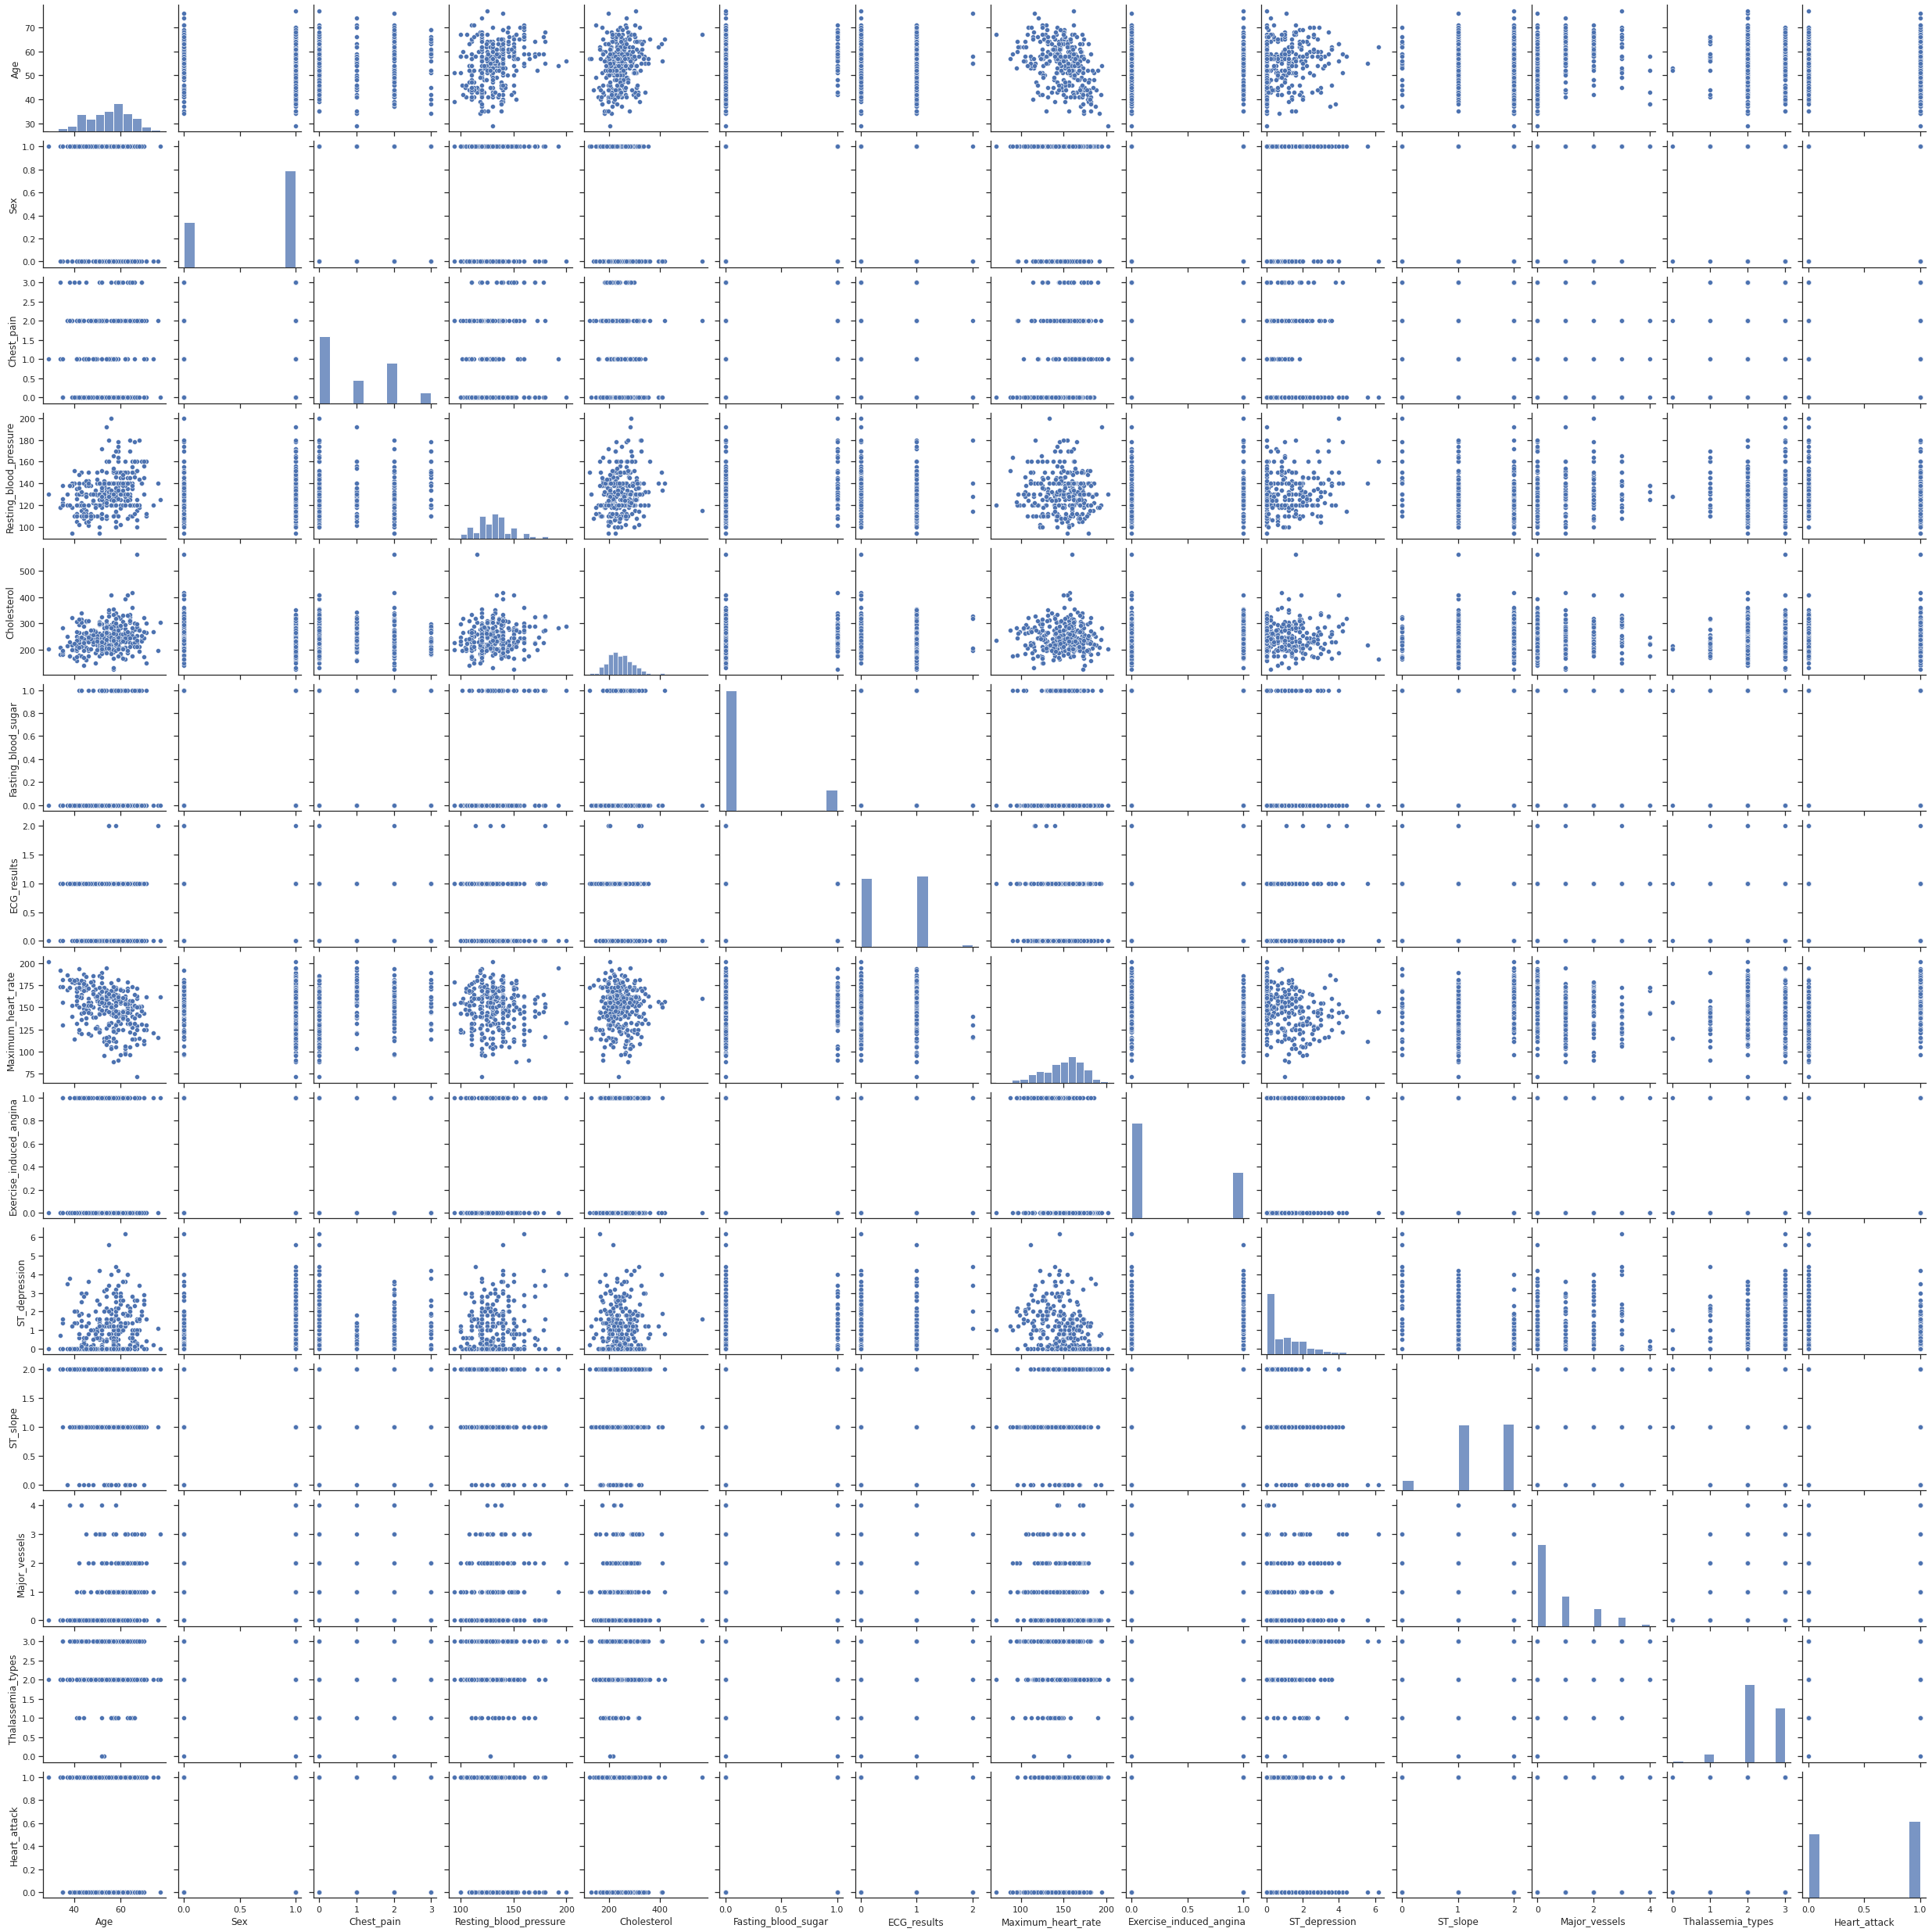

In [40]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df)
plt.plot()

This shows overall relationship between all the columns in the DataFrame.


The overall graphical analysis shows that females tend to suffer less from heart attack and that men have a higher chances of getting struck by a heart attack.


Men don't have a defined age span that they are safe from heart attack. Men below 30 also suffered from heart attack which wasn't the case with women. This shows men have to be more careful with their health conditions and situations.
Age was not such a huge critera for suffering from heart attack and rest of the parameters had very little relation amongst themselves. The tests taken showed various results where the patterns showed that the heart attack conditions could have been diagonsed a bit earlier.


If you go for some tests and the results are not good, then better proceedings need to be taken to avoid heart attack. Otherwise, there is no avoiding a heart attack.


## Model Selection and Training

In [41]:
#Libraries for model selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#Libraries for various model parameter selection.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# from pandas import DataFrame
# from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

In [42]:
# prepare train/test dataset
x_train_df, x_test_df, y_train, y_test = train_test_split(df.drop(TARGET_COLUMN, axis=1),
                                                          df[TARGET_COLUMN].values,
                                                          test_size = 0.20,
                                                          random_state = SEED)

In [43]:
print('Categorial columns:', CAT_COLUMNS)
cat_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
cat_encoder.fit(x_train_df[CAT_COLUMNS].values)
cat_encoder.categories_

Categorial columns: ['Chest_pain', 'Thalassemia_types', 'ECG_results', 'ST_slope', 'Major_vessels']


[array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2, 3, 4])]

In [44]:
print('Numerical columns:', NUM_COLUMNS)
num_scaler = MinMaxScaler(copy=True)
num_scaler.fit(x_train_df[NUM_COLUMNS].values)
num_scaler.scale_

Numerical columns: ['Age', 'Sex', 'Resting_blood_pressure', 'Cholesterol', 'Fasting_blood_sugar', 'Maximum_heart_rate', 'Exercise_induced_angina', 'ST_depression']


array([0.0212766 , 1.        , 0.01020408, 0.00228311, 1.        ,
       0.00892857, 1.        , 0.16129032])

In [45]:
x_train = np.hstack([num_scaler.transform(x_train_df[NUM_COLUMNS].values), cat_encoder.transform(x_train_df[CAT_COLUMNS].values)])
x_test = np.hstack([num_scaler.transform(x_test_df[NUM_COLUMNS].values), cat_encoder.transform(x_test_df[CAT_COLUMNS].values)])

In [46]:
# list which will store the accuracy value for all models used.

accuracy = []

## Models

In [47]:
FOLDS = 5

### Logistic Regression

In [48]:
C = [0.01, 0.1, 1, 2, 5, 10, 20]
parameters = {'C': C, 'random_state': RANDOM_STATES}

estimator = LogisticRegression

best_params = search_best_parameters(estimator(), parameters, FOLDS, x_train, y_train)
model, acc = build_model(estimator(**best_params), x_train, y_train, x_test, y_test)
accuracy.append(acc)

print(f'Model: {estimator.__name__}, best parameters: {best_params}, accuraty: {acc * 100:.2f}')

Model: LogisticRegression, best parameters: {'C': 0.01, 'random_state': 1}, accuraty: 83.61


[]

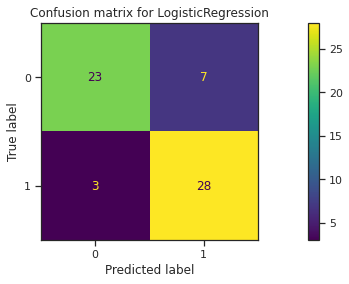

In [49]:
plot_confusion_matrix(model, x_test, y_test)
plt.title(f'Confusion matrix for {estimator.__name__}')
plt.plot()

&nbsp;  
This shows there were problem in only 10 values, otherwise all the values were predicted right.

### Decision Trees

In [50]:
criterion = ['gini', 'entropy']
splitter = ['best', 'random']

parameters = {'criterion': criterion, 'splitter': splitter, 'random_state': RANDOM_STATES}

estimator = DecisionTreeClassifier

best_params = search_best_parameters(estimator(), parameters, FOLDS, x_train, y_train)
model, acc = build_model(estimator(**best_params), x_train, y_train, x_test, y_test)
accuracy.append(acc)

print(f'Model: {estimator.__name__}, best parameters: {best_params}, accuraty: {acc * 100:.2f}')

Model: DecisionTreeClassifier, best parameters: {'criterion': 'entropy', 'random_state': 111, 'splitter': 'random'}, accuraty: 83.61


[]

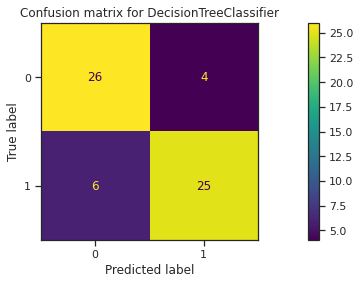

In [51]:
plot_confusion_matrix(model, x_test, y_test)
plt.title(f'Confusion matrix for {estimator.__name__}')
plt.plot()

This shows there were problem in 10 values, otherwise all the values were predicted right.

### Multinomial Naive Bayes

In [52]:
alpha = [0.1, 0.2, 0.5, 0.8, 1., 1.2, 1.5, 2, 3, 5, 10]
parameters = {'alpha': alpha}

estimator = MultinomialNB

best_params = search_best_parameters(estimator(), parameters, FOLDS, x_train, y_train)
model, acc = build_model(estimator(**best_params), x_train, y_train, x_test, y_test)
accuracy.append(acc)

print(f'Model: {estimator.__name__}, best parameters: {best_params}, accuraty: {acc * 100:.2f}')

Model: MultinomialNB, best parameters: {'alpha': 1.5}, accuraty: 88.52


[]

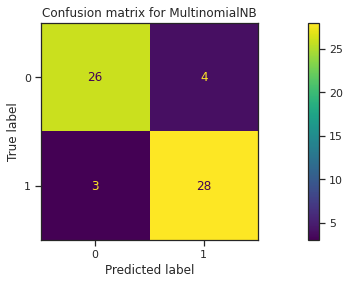

In [53]:
plot_confusion_matrix(model, x_test, y_test)
plt.title(f'Confusion matrix for {estimator.__name__}')
plt.plot()

This shows there were problem in 7 values, otherwise all the values were predicted right.

### Random Forest Classifier

In [54]:
n_estimators = [100, 120, 150, 200, 250]
criterion = ['gini', 'entropy']
max_features = ['auto', 'sqrt', 'log2']

parameters = {'n_estimators': n_estimators,
              'criterion': criterion,
              'max_features': max_features,
              'random_state': RANDOM_STATES}

estimator = RandomForestClassifier

best_params = search_best_parameters(estimator(), parameters, FOLDS, x_train, y_train)
model, acc = build_model(estimator(**best_params), x_train, y_train, x_test, y_test)
accuracy.append(acc)

print(f'Model: {estimator.__name__}, best parameters: {best_params}, accuraty: {acc * 100:.2f}')

Model: RandomForestClassifier, best parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 150, 'random_state': 111}, accuraty: 91.80


[]

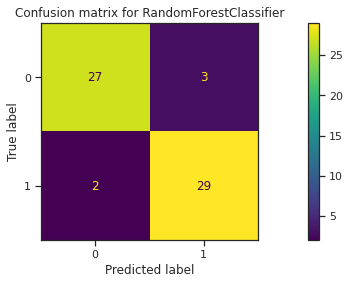

In [55]:
plot_confusion_matrix(model, x_test, y_test)
plt.title(f'Confusion matrix for {estimator.__name__}')
plt.plot()

This shows there were problem in 5 values, otherwise all the values were predicted righ

### K-Nearest Neighbors

In [56]:
k_range = list(range(2, 30))

parameters = {'n_neighbors': k_range}

estimator = KNeighborsClassifier

best_params = search_best_parameters(estimator(), parameters, FOLDS, x_train, y_train)
model, acc = build_model(estimator(**best_params), x_train, y_train, x_test, y_test)
accuracy.append(acc)

print(f'Model: {estimator.__name__}, best parameters: {best_params}, accuraty: {acc * 100:.2f}')

Model: KNeighborsClassifier, best parameters: {'n_neighbors': 29}, accuraty: 86.89


[]

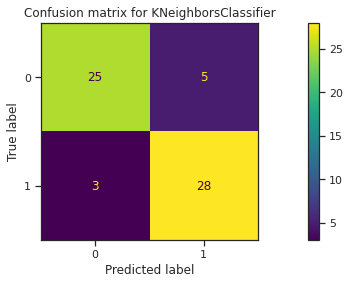

In [57]:
plot_confusion_matrix(model, x_test, y_test)
plt.title(f'Confusion matrix for {estimator.__name__}')
plt.plot()

This shows there were problem only in 8 values, otherwise all the values were predicted righ.

### Overall accuracies obtained by the models

In [58]:
models = ['Logistic Regression', 'Decision Tree', 'Multinomial NB', 'Random Forest Classifier', 'K-Nearest Neighbors']
total = list(zip(models, accuracy))
output = pd.DataFrame(total, columns = ['Models','Accuracy'])
s = output.groupby(['Models'])['Accuracy'].mean().reset_index().sort_values(by = 'Accuracy', ascending = False)
s.head(5).style.background_gradient(cmap='Reds')

,Models,Accuracy
4,Random Forest Classifier,0.918033
3,Multinomial NB,0.885246
1,K-Nearest Neighbors,0.868852
0,Decision Tree,0.836066
2,Logistic Regression,0.836066


&nbsp;  
This shows the accuracy of all the models that were obtained in a descending format.